#Tensorflow Model

In [ ]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
print(tf.__version__)

2.4.0


Mount ur google drive and plce your food images data

In [ ]:
import pathlib
import os
import shutil

dataset_path_in_drive = "/content/drive/MyDrive/training_data/demo_data_for_food_app_blog"

data_dir = pathlib.Path(dataset_path_in_drive)

food_dict_with_img_loc = {'tacos': list(data_dir.glob('tacos/*')), 'pizza': list(data_dir.glob('pizza/*'))
                          }




         

In [ ]:
present_dir = dataset_path_in_drive

# Makes 2 floders called train and validation 

os.makedirs(os.path.join(present_dir, 'train'))
os.makedirs(os.path.join(present_dir, 'validation'))

train_dir = os.path.join(present_dir, 'train')

val_dir = os.path.join(present_dir, 'validation')


# Splitting the main dataset to train and test ( train 80 % and validation 20 % )

for food_name, images_locs in food_dict_with_img_loc.items():
    len_of_images = len(images_locs)
    for i in range(0, round(0.8 * len_of_images)):  # ies split 80 to train and rest( 20 %) to validation set

        if i == 0:
            os.makedirs(os.path.join(train_dir, food_name))
        food_dir_in_train = os.path.join(train_dir, food_name)
        shutil.copy(food_dict_with_img_loc[food_name][i], food_dir_in_train)

for food_name, images_locs in food_dict_with_img_loc.items():
    len_of_images = len(images_locs)
    for i in range(round(0.8 * len_of_images), len_of_images):
        if i == round(0.8 * len_of_images):  # ie 1st iteration
            os.makedirs(os.path.join(val_dir, food_name))
        food_dir_in_val = os.path.join(val_dir, food_name)
        shutil.copy(food_dict_with_img_loc[food_name][i], food_dir_in_val)


In [ ]:
train_dir='/content/drive/MyDrive/training_data/demo_data_for_food_app_blog/train'
val_dir='/content/drive/MyDrive/training_data/demo_data_for_food_app_blog/validation'

total_train = 0

for food_name,images_locs in food_dict_with_img_loc.items():
  total_train+=round(0.8*len(images_locs))



total_val = 0

for food_name,images_locs in food_dict_with_img_loc.items():
  total_val+=round(0.2*len(images_locs))


total_train,total_val 

(86, 22)

Loading In the images and applying Data Augmentation

In [ ]:
BATCH_SIZE = 100
IMG_SHAPE  = 224 
no_of_output_layers=2

image_gen_train = ImageDataGenerator(     # here we use the ImageDataGenerator 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,                # Applaying these all Data Augmentations
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,     # Batch siz emeans at a time it takes 100
                                                     directory=train_dir,    # Here we put shuffle= True so tat model doesnt memorise order
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


Loading the MobileNet Model from tensorflow hub

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE,3))

feature_extractor.trainable = False     # so that model doesnt not train from scratch again





from tensorflow.keras import layers

# defining the model

model = tf.keras.Sequential([
  feature_extractor, 
  layers.Dense(no_of_output_layers)   # make sure this number is the same number as output classes
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Compiling the model and training the model

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

epochs= 12
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))) )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
1/1 [==============================] - 22s 22s/step - loss: 0.8001 - accuracy: 0.4884 - val_loss: 0.5338 - val_accuracy: 0.6818
Epoch 2/12
1/1 [==============================] - 2s 2s/step - loss: 0.6911 - accuracy: 0.6279 - val_loss: 0.4659 - val_accuracy: 0.8182
Epoch 3/12
1/1 [==============================] - 2s 2s/step - loss: 0.6050 - accuracy: 0.6395 - val_loss: 0.4126 - val_accuracy: 0.8636
Epoch 4/12
1/1 [==============================] - 2s 2s/step - loss: 0.5124 - accuracy: 0.7209 - val_loss: 0.3709 - val_accuracy: 0.9091
Epoch 5/12
1/1 [==============================] - 2s 2s/step - loss: 0.4548 - accuracy: 0.8023 - val_loss: 0.3414 - val_accuracy: 0.9091
Epoch 6/12
1/1 [==============================] - 2s 2s/step - loss: 0.4053 - accuracy: 0.8605 - val_loss: 0.3139 - val_accuracy: 0.9091
Epoch 7/12
1/1 [==============================] - 1s 1s/step - loss: 0.3594 - accuracy: 0.8256 - val_loss: 0.2878 - val_accuracy: 0.9545
Epoch 8/12
1/1 [=======================

We got really high accuracy ,without overfitting





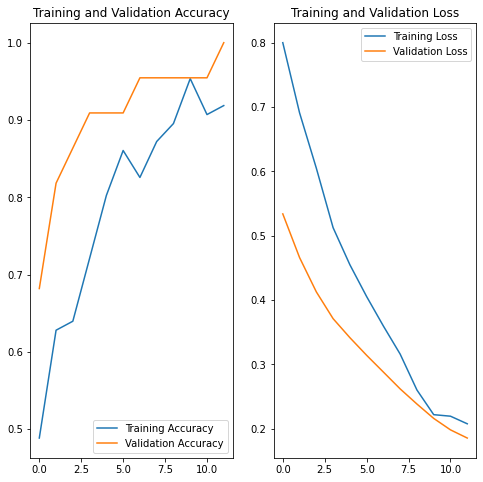

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

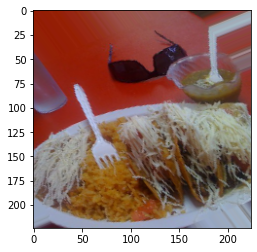

In [ ]:
plt.imshow(train_data_gen[0][0][6])

Checking if the model is working

In [ ]:
img=train_data_gen[0][0][6]

img=np.array([img])
print(img.shape)
prediction=model.predict(img)
prediction


flowers_dict_names={0:'pizza',1:'tacos'
              }
flowers_dict_names[np.argmax(prediction)]

(1, 224, 224, 3)


'tacos'

In [ ]:
print(train_data_gen[0][1][6])

1.0


Converting tensorflow model to tflite

In [ ]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]  # To reduce size of model
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = "food.tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_78534ov/assets


INFO:tensorflow:Assets written to: /tmp/tmp_78534ov/assets


2707600

Checking if the .tflite model is working

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="food.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[-0.61096084 -0.41313863]]
